# Conformalized Quantile Regression

In [1]:
# All libraries are imported from the python file 'libraries' 
# we seperated it from the notebook for shortening 
from libraries import *

2022-08-22 09:51:43.701564: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 09:51:43.880840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 09:51:43.880883: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load & Preprocess data

In [2]:
data = pd.read_excel("../../../Data/dense_data.xlsx")
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)
def select_columns(df, col_type=None):
    """
    Select columns from a dataframe by type.
    """
    if col_type == "numerical":
        return df.select_dtypes(exclude=['object'])
    elif col_type == "categorical":
        return df.select_dtypes(include=['object'])
    else:
        raise ValueError("col_type should be numerical or categorical")

# Create the preprocessing pipelines for numerical data.
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean', verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = Pipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical', Pipeline(steps=[
        ('get_num_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="numerical"))),
        ('transformer', numerical_transformer)])),
    ('categorical', Pipeline(steps=[
        ('get_cat_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="categorical"))),
        ('transformer',categorical_transformer)]))
    ])) 
])
X_encoded = preprocessor.fit_transform(X)

## Split Data

In [3]:
TEST_SIZE = 0.1 #define test size 0.1 = 10% of the data

#split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=TEST_SIZE)
print(f"\nX_train : {len(X_train)}  |  X_test : {len(X_test)} ")
print(f"y_train : {len(y_train)}  |  y_test : {len(y_test)} ")


X_train : 6582  |  X_test : 732 
y_train : 6582  |  y_test : 732 


## CQR Model using MAPIE

In [4]:
# CHOOSE THE RISK LEVEL ALPHA WHICH REPRESENTS 1-ALPHA CONFIDENCE.
alpha = 0.1

#instanciate the Quantile Regressor from MAPIE
#keep it empty to choose default regression algorithm = 'QuantileRegression'
model = MapieQuantileRegressor(method="quantile", alpha = alpha)

#fit the model
g = model.fit(X_train, y_train, random_state=1)

In [5]:
# predict test set and return the prediction and the lower, upper bounds ( y_pis )
y_pred, y_pis = model.predict(X_test, alpha=alpha)
mediane = g.estimators_[2].predict(X_test)

# predict train set and return the prediction and the lower, upper bounds ( y_pis )
y_pred_train, y_pis_train = model.predict(X_train, alpha=alpha)
mediane_train = g.estimators_[2].predict(X_train)

## Retrieve quantiles

In [6]:
#split y_pis to get the lower bound and the upper bound of the TEST set
lower = y_pis[:, 0, :]
lower = lower.reshape(y_test.shape)
upper = y_pis[:, 1, :]
upper = upper.reshape(y_test.shape)


#split y_pis to get the lower bound and the upper bound of the TRAIN set
lower_train = y_pis_train[:, 0, :]
lower_train = lower_train.reshape(y_train.shape)

upper_train = y_pis_train[:, 1, :]
upper_train = upper_train.reshape(y_train.shape)

In [7]:
print(f"{lower.shape}{upper.shape}{y_test.shape}")
print(f"{lower_train.shape}{upper_train.shape}{y_train.shape}")

(732,)(732,)(732,)
(6582,)(6582,)(6582,)


In [8]:
def compute_coverage_len(y_test, y_lower, y_upper):
    in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
    coverage = in_the_range / len(y_test) * 100
    avg_length = np.mean(abs(y_upper - y_lower))
    return coverage, avg_length

In [9]:
coverage_test, avg_length_test = compute_coverage_len(list(y_test), lower, upper)
coverage_train, avg_length_train = compute_coverage_len(y_train, lower_train, upper_train)

## Results 

In [10]:
print(f" The coverage of the test set is : {round(coverage_test,7)}% \n The average lenght is : {round(avg_length_test,5)}")

print(f"\n The coverage of the train set is : {round(coverage_train,5)}% \n The average lenght is : {round(avg_length_train,5)}")

 The coverage of the test set is : 89.7540984% 
 The average lenght is : 0.74991

 The coverage of the train set is : 95.54847% 
 The average lenght is : 0.73502


<AxesSubplot:xlabel='Residual error', ylabel='Density'>

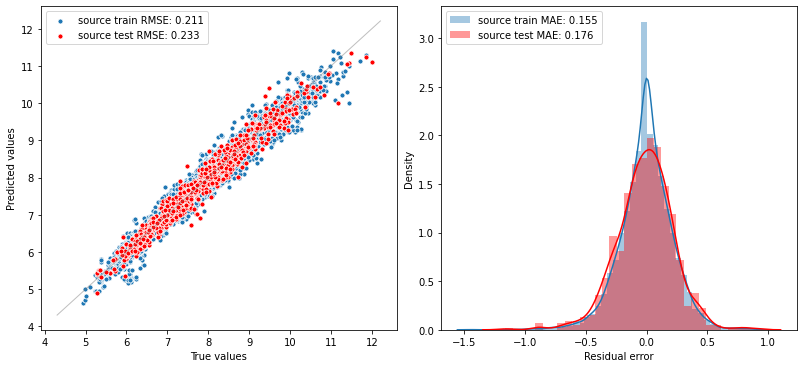

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]); 

plot_adequation(y_train, y_pred_train, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, y_pred, label='source test', ax=ax1, plot_line=False, score='RMSE', color='red')



plot_residuals(y_train, y_pred_train, kind='hist', label='source train', ax=ax2, score='MAE')
plot_residuals(y_test, y_pred, kind='hist', label='source test', ax=ax2, score='MAE', color='red')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

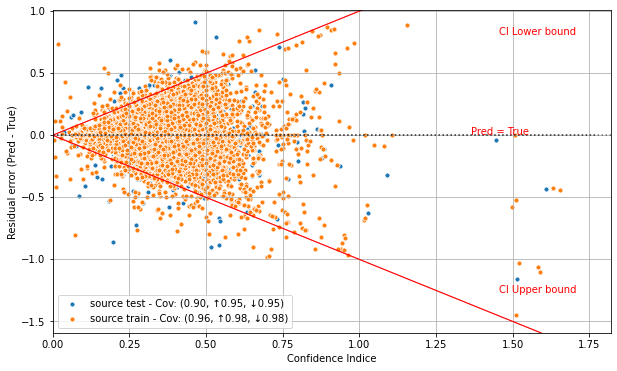

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(24, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
plt.grid(True)

plot_confidence_v2(y_test,y_pred , lower,  upper, ax=ax1, label='source test')
plot_confidence_v2(y_train,y_pred_train , lower_train,  upper_train,ax = ax1, label='source train')


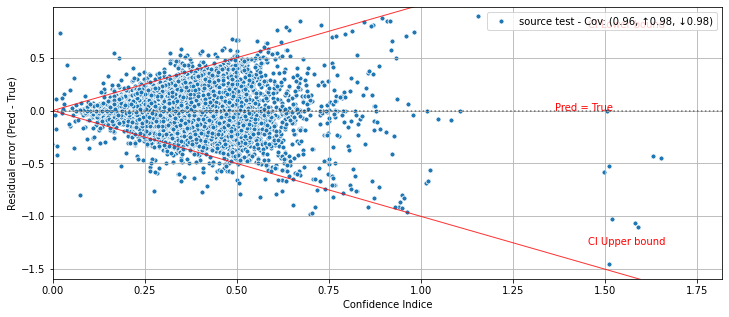

In [13]:
plot_confidence_v2(y_train,y_pred_train , lower_train,  upper_train, label='source test')
plt.grid(True)

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

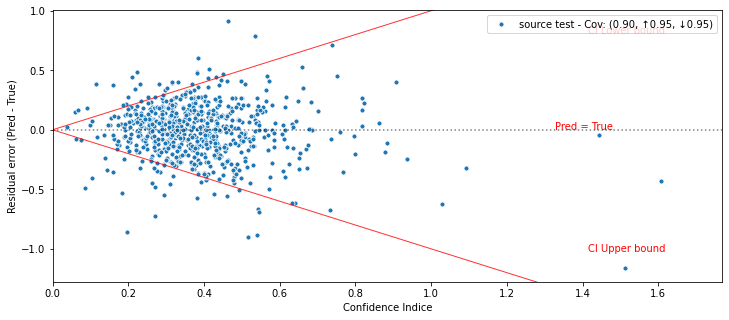

In [14]:
plot_confidence_v2(y_test,y_pred , lower,  upper, label='source test')

Text(0.5, 0, 'Confidence Indice')

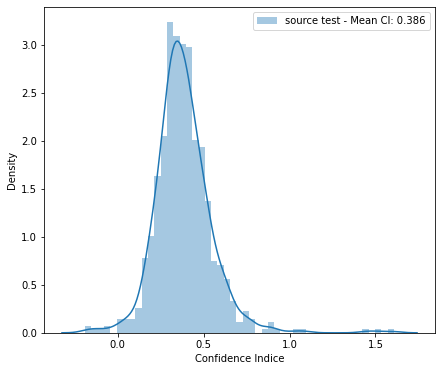

In [15]:
#plot_residuals(y_train_pred, y_train_q95, kind='hist', label='source train - Mean CI:', score=mean_absolute_error, ax=ax5)
plot_residuals(y_pred, upper, kind='hist', label='source test - Mean CI:', score=mean_absolute_error)
plt.xlabel("Confidence Indice")

In [16]:
import sys

In [18]:
p0_05 = lower.copy()
p0_5 = mediane.copy()
p0_95 = upper.copy()

In [19]:
p0_5.shape

(732,)

## Estimate the Mean and the variance from quantiles

In this case, as the method do not output the variance which we need to compute several metrics with, we used the **Extended Pearson-Tukey method**

By having $p_{0.05}, p_{0.5}$ and $p_{0.95}$
$$\hat{\mu} = 0.630.p_{0.5} + 0.185.(p_{0.05}+p_{0.95}) $$
$$ \hat{\sigma}^2 = 0.630(p_{0.5}-\hat{\mu})^2+0.185[(p_{0.05}-\hat{\mu})^2 + (p_{0.95}-\hat{\mu})^2] $$

In [20]:
def pearson_tukey(p0_05, p0_5, p0_95):
    mu = 0.63*p0_5 + 0.185*(p0_05+p0_95)
    std = 0.63*(p0_5-mu)**2+0.185*((p0_05-mu)**2 + (p0_95-mu)**2)
    return mu, std

In [21]:
mu, stds = pearson_tukey(p0_05, p0_5, p0_95)

In [22]:
import seaborn as sns

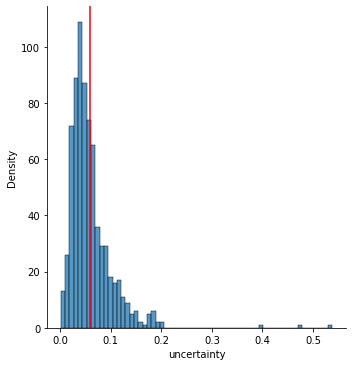

In [23]:
#plt.figure(figsize=(10,8))
sns.displot(stds)
plt.axvline(np.mean(stds), color='red')
#plt.legend(['mean of stdvs','std for each tire preds'])
plt.xlabel("uncertainty")
plt.ylabel("Density")
plt.show()

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

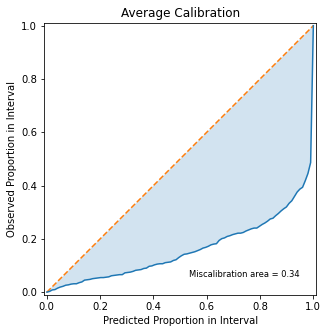

In [24]:
uct.viz.plot_calibration(np.array(y_pred),  np.array(stds), np.array(y_test))

In [25]:
all_metrics = uct.get_all_metrics(np.array(y_pred),np.array(stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.176
  RMSE          0.233
  MDAE          0.138
  MARPD         2.238
  R2            0.963
  Correlation   0.981
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.384
  Mean-absolute Calibration Error       0.336
  Miscalibration Area                   0.340
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.373
     Group Size: 0.56 -- Calibration Error: 0.350
     Group Size: 1.00 -- Calibration Error: 0.336
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.421
     Group Size: 0.56 -- Calibration Error: 0.399
     Group Size: 1.00 -- Calibration Error: 0.384
================

## Re-calibration

In [26]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(y_pred), np.array(stds), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(stds))

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

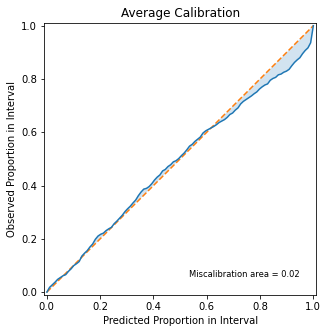

In [27]:
uct.viz.plot_calibration(np.array(y_pred),  np.array(new_stds), np.array(y_test))

In [29]:
all_metrics_calib = uct.get_all_metrics(np.array(y_pred),np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.67it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.176
  RMSE          0.233
  MDAE          0.138
  MARPD         2.238
  R2            0.963
  Correlation   0.981
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.029
  Mean-absolute Calibration Error       0.021
  Miscalibration Area                   0.021
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.076
     Group Size: 0.56 -- Calibration Error: 0.031
     Group Size: 1.00 -- Calibration Error: 0.021
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.082
     Group Size: 0.56 -- Calibration Error: 0.039
     Group Size: 1.00 -- Calibration Error: 0.029
================

## Save metrics

In [30]:
import pickle

In [31]:
with open('CQR_metrics_dense.pkl', 'wb') as f:
    pickle.dump(all_metrics_calib, f)